# PCA
Principal Component Analysis (PCA) is a dimensionality reduction technique widely used to transform high-dimensional data into a lower-dimensional space while retaining the most important information. It begins by computing the covariance matrix of the input data, summarizing the relationships between different features. From this matrix, PCA calculates the eigenvectors and eigenvalues, where eigenvectors represent the directions of maximum variance and eigenvalues quantify the amount of variance explained by each eigenvector. The top k eigenvectors, corresponding to the largest eigenvalues, are selected as principal components. These components capture the most significant sources of variation in the data. By projecting the original data onto these principal components, PCA creates a lower-dimensional representation that preserves most of the important information. In the context of addressing imbalanced test sets, PCA's dimensionality reduction capabilities can help by focusing on the features contributing the most to class discrimination. This can enhance discriminability between different classes and mitigate overfitting, leading to improved classifier performance on imbalanced datasets.

In [ ]:
SimpleNN:
Accuracy: 0.6667
Precision: 0.5000
Recall: 0.7500

XGBoost:
Accuracy: 0.7500
T Precision: 1.0000
Test Recall: 0.2500

SVC: 
Accuracy: 0.7500
Precision: 1.0000
Recall: 0.2500

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from graphviz import Source
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import random
import numpy as np

# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

COMPONENTS = 4

In [2]:
df = pd.read_csv('../heart_failure_clinical_records_dataset.csv')

In [3]:
target = 'DEATH_EVENT'
features = df.columns[df.columns != target]

In [4]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [6]:
# List of columns to be standardized
columns_to_standardize = df.columns.difference(['anemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT'])

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

class_counts = df['DEATH_EVENT'].value_counts()
print(f"Class distribution:\n{class_counts}")

Class distribution:
0    203
1     96
Name: DEATH_EVENT, dtype: int64


In [7]:
# Split dataset into train, validation, and test
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.2, random_state=42)

In [8]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import torch

# Extract features and target variable
X_train = df_train.drop('DEATH_EVENT', axis=1).values
y_train = df_train['DEATH_EVENT'].values

# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Apply PCA on the training set
pca = PCA(n_components=COMPONENTS)  # Set the desired number of components
X_train_pca = pca.fit_transform(X_train)

# Transform validation and test sets using the same PCA instance
X_val_pca = pca.transform(df_val.drop('DEATH_EVENT', axis=1).values)
X_test_pca = pca.transform(df_test.drop('DEATH_EVENT', axis=1).values)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_tensor = torch.tensor(df_val['DEATH_EVENT'].values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(df_test['DEATH_EVENT'].values, dtype=torch.float32)


In [9]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)  # No sigmoid here
        return x


Training Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 1, Loss: 1.1554003953933716, Accuracy: 58.666666666666664%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 1, Val Loss: 1.077436089515686, Val Accuracy: 0.6944444444444444


Training Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 2, Loss: 0.8850718259811401, Accuracy: 64.33333333333333%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 2, Val Loss: 1.854033350944519, Val Accuracy: 0.3472222222222222


Training Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 3, Loss: 0.6975892782211304, Accuracy: 49.333333333333336%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 3, Val Loss: 2.0097489655017853, Val Accuracy: 0.375


Training Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 4, Loss: 0.6082082271575928, Accuracy: 51.33333333333333%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 4, Val Loss: 3.345977008342743, Val Accuracy: 0.3333333333333333


Training Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 5, Loss: 0.5461739897727966, Accuracy: 14.333333333333334%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 5, Val Loss: 3.4130194187164307, Val Accuracy: 0.041666666666666664


Training Epoch 6:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 6, Loss: 0.509039169549942, Accuracy: 3.6666666666666665%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 6, Val Loss: 3.462013840675354, Val Accuracy: 0.027777777777777776


Training Epoch 7:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 7, Loss: 0.4993264079093933, Accuracy: 2.3333333333333335%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 7, Val Loss: 4.065073072910309, Val Accuracy: 0.041666666666666664


Training Epoch 8:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 8, Loss: 0.5248745858669281, Accuracy: 1.6666666666666667%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 8, Val Loss: 3.0397318601608276, Val Accuracy: 0.08333333333333333


Training Epoch 9:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 9, Loss: 0.5991762101650238, Accuracy: 2.3333333333333335%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 9, Val Loss: 2.950920283794403, Val Accuracy: 0.041666666666666664


Training Epoch 10:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 10, Loss: 0.49362083077430724, Accuracy: 2.666666666666667%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 10, Val Loss: 4.314954161643982, Val Accuracy: 0.013888888888888888


Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 0.7222
Precision: 0.7500
Recall: 0.6667


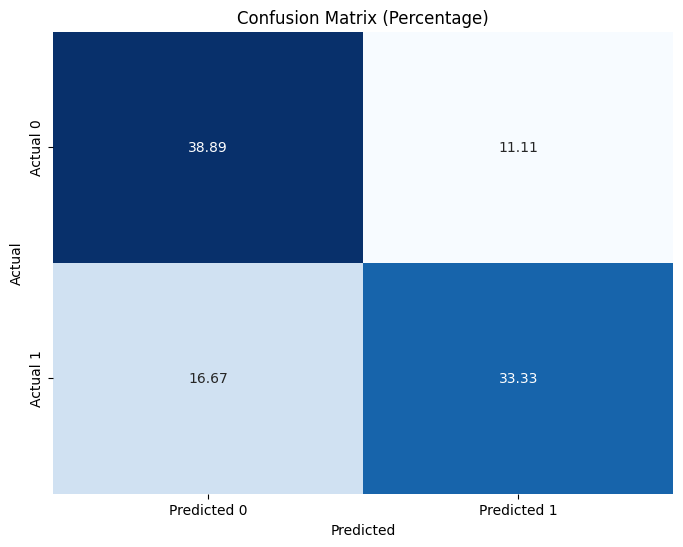

In [66]:
weight = 3.0

# Adjust the input size of the SimpleNN model
input_size = X_train_pca.shape[1]  # Number of components after LDA
model = SimpleNN(input_size=input_size, hidden_size1=20, hidden_size2=10, hidden_size3=2, output_size=1)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weight])) 

optimizer = optim.Adam(model.parameters(), lr=0.04910009)  # Add weight decay for L2 regularization

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
EPOCHS = 10
# Training function
# Modify the train function to work with the pipeline
def train(train_loader, val_loader, criterion, optimizer, model, epochs=EPOCHS):
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total_samples = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute training accuracy
            predicted = torch.round(outputs)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total_samples += labels.size(0)

        accuracy = correct / total_samples
        print(f"Training Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}, Accuracy: {accuracy * 100}%")

        validation(model, val_loader, criterion, epoch)


# Evaluate function for validation
def validation(model, val_loader, criterion, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            total_loss += loss.item()
            predicted = torch.round(outputs)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total_samples += labels.size(0)
    accuracy = correct / total_samples
    print(f"Validation Epoch {epoch+1}, Val Loss: {total_loss / len(val_loader)}, Val Accuracy: {accuracy}")

# Evaluate function for testing
# Update the test function
def test(model, test_loader, criterion, threshold=0.4):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            total_loss += loss.item()

            # Convert probability outputs to binary predictions using the threshold
            predicted = (outputs >= threshold).float()

            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total_samples += labels.size(0)
            
            # Store labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total_samples
    conf_matrix = confusion_matrix(all_labels, np.round(all_predictions))
    # Calculate evaluation metrics
    precision = precision_score(all_labels, np.round(all_predictions), zero_division=1)
    recall = recall_score(all_labels, np.round(all_predictions))

    
   # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix / total_samples * 100, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()


# Training loop
train(train_loader, val_loader, criterion, optimizer, model, epochs=EPOCHS)

# Testing
test(model, test_loader, criterion, threshold=0.4)

Epoch [10/300], Loss: 0.9318
Epoch [20/300], Loss: 0.9112
Epoch [30/300], Loss: 0.8914
Epoch [40/300], Loss: 0.8723
Epoch [50/300], Loss: 0.8540
Epoch [60/300], Loss: 0.8363
Epoch [70/300], Loss: 0.8194
Epoch [80/300], Loss: 0.8031
Epoch [90/300], Loss: 0.7875
Epoch [100/300], Loss: 0.7726
Epoch [110/300], Loss: 0.7583
Epoch [120/300], Loss: 0.7446
Epoch [130/300], Loss: 0.7315
Epoch [140/300], Loss: 0.7189
Epoch [150/300], Loss: 0.7069
Epoch [160/300], Loss: 0.6954
Epoch [170/300], Loss: 0.6844
Epoch [180/300], Loss: 0.6738
Epoch [190/300], Loss: 0.6638
Epoch [200/300], Loss: 0.6541
Epoch [210/300], Loss: 0.6449
Epoch [220/300], Loss: 0.6361
Epoch [230/300], Loss: 0.6276
Epoch [240/300], Loss: 0.6195
Epoch [250/300], Loss: 0.6118
Epoch [260/300], Loss: 0.6043
Epoch [270/300], Loss: 0.5972
Epoch [280/300], Loss: 0.5904
Epoch [290/300], Loss: 0.5839
Epoch [300/300], Loss: 0.5776
Accuracy: 0.5556
Precision: 0.5714
Recall: 0.4444


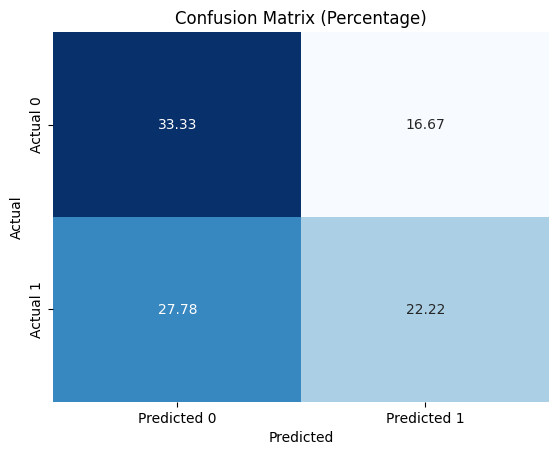

In [16]:
# Linear Regression

# Assuming input_size is the number of features in your dataset
input_size = X_train_tensor.shape[1]

# Define a simple logistic regression model
linear_model = nn.Linear(input_size, 1)
sigmoid = nn.Sigmoid()

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.SGD(linear_model.parameters(), lr=.0065)  # Set a fixed learning rate

# Training loop
epochs = 300
for epoch in range(epochs):
    # Forward pass
    outputs = linear_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))  # Ensure the shape matches

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# After training, you can use the trained model to make predictions on the test set
test_predictions = sigmoid(linear_model(X_test_tensor))

# Convert probabilities to class labels (0 or 1)
predicted_labels = (test_predictions >= 0.50).int()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_tensor.numpy().astype(int), predicted_labels.detach().numpy())
precision = precision_score(y_test_tensor.numpy().astype(int), predicted_labels.detach().numpy(), zero_division=1)
recall = recall_score(y_test_tensor.numpy().astype(int), predicted_labels.detach().numpy())

# Print or use the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Create confusion matrix for the test set
conf_matrix = confusion_matrix(y_test_tensor.numpy(), predicted_labels.detach().numpy())

# Plot the confusion matrix using seaborn with percentages
total_samples = len(y_test_tensor)
sns.heatmap(conf_matrix / total_samples * 100, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()


Best Parameters: {'learning_rate': 0.99, 'max_depth': 5, 'n_estimators': 116, 'subsample': 0.9}
Validation Accuracy: 0.8194
Validation Precision: 0.8261
Validation Recall: 0.6786
Test Accuracy: 0.7222
Test Precision: 1.0000
Test Recall: 0.4444


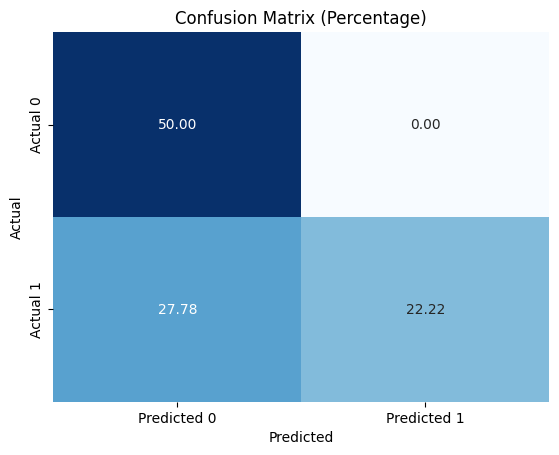

In [17]:
# XGBoost

# Convert data to NumPy arrays for XGBoost
X_train_numpy = X_train_tensor.numpy()
y_train_numpy = y_train_tensor.numpy()

X_val_numpy = X_val_tensor.numpy()
y_val_numpy = y_val_tensor.numpy()

X_test_numpy = X_test_tensor.numpy()
y_test_numpy = y_test_tensor.numpy()

param_grid = {
    'learning_rate': [0.90, 0.99, 0.9999, .999999], #
    'max_depth': [3, 4, 5 ,6], # -
    'n_estimators': [114 ,116], #
    'subsample': [0.8, 0.9, 1.0], #
}

# Create XGBoost classifier
xgb_classifier = XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train_numpy, y_train_numpy)

# Fit the model to the training data using the best parameters
best_xgb_classifier = grid_search.best_estimator_
best_xgb_classifier.fit(X_train_numpy, y_train_numpy)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to make predictions on the validation set
val_predictions = best_xgb_classifier.predict(X_val_numpy)

# Calculate metrics on the validation set
val_accuracy = accuracy_score(y_val_numpy, val_predictions)
val_precision = precision_score(y_val_numpy, val_predictions)
val_recall = recall_score(y_val_numpy, val_predictions)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')

# Use the best model to make predictions on the test set
test_predictions = best_xgb_classifier.predict(X_test_numpy)

# Calculate metrics on the test set
test_accuracy = accuracy_score(y_test_numpy, test_predictions)
test_precision = precision_score(y_test_numpy, test_predictions)
test_recall = recall_score(y_test_numpy, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Create confusion matrix for the test set
conf_matrix_XG = confusion_matrix(y_test_numpy, test_predictions)

# Plot the confusion matrix using seaborn with percentages
total_samples = len(y_test_tensor)
sns.heatmap(conf_matrix_XG / total_samples * 100, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

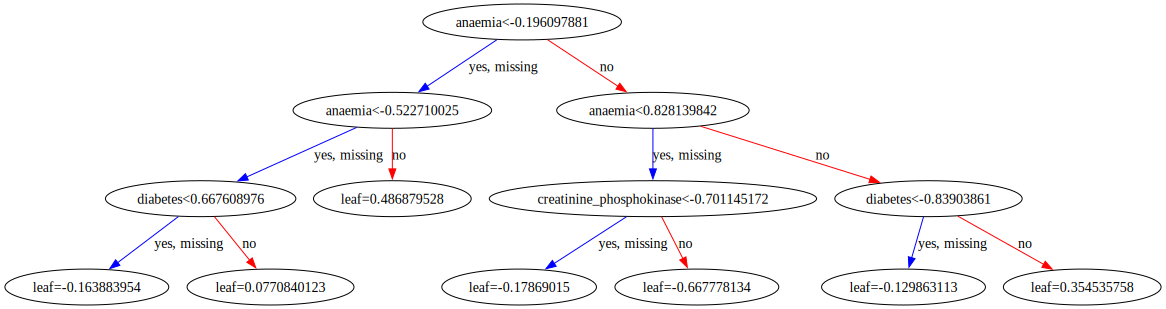

In [18]:

tree_index = 10

# Get the DOT data for the chosen tree with feature names
dot_data = xgb.to_graphviz(best_xgb_classifier, num_trees=tree_index, feature_names=features).source

# Replace the default feature names in the DOT data
for feature_name in features:
    dot_data = dot_data.replace(f'f{features.get_loc(feature_name)}', feature_name)

# Display the decision tree directly in the notebook
Source(dot_data)

In [19]:
# SVM
# Define the parameter grid
param_grid = {'C': [ 3,4,5], 'gamma': [0.1,0.2, 0.25,.001], 'kernel': ['linear', 'poly', 'sigmoid']}

# Initialize SVM classifier
svm_classifier = SVC(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_pca, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(f'Best Parameters: {best_params}')

# Use the best model for predictions
best_svm_classifier = grid_search.best_estimator_
y_pred = best_svm_classifier.predict(X_test_pca)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_numpy, y_pred)
precision = precision_score(y_test_numpy, y_pred, zero_division=1)
recall = recall_score(y_test_numpy, y_pred)

# Output the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

conf_matrix_SVM = confusion_matrix(y_test_numpy, y_pred)




Best Parameters: {'C': 4, 'gamma': 0.001, 'kernel': 'sigmoid'}
Accuracy: 0.8333
Precision: 1.0000
Recall: 0.6667


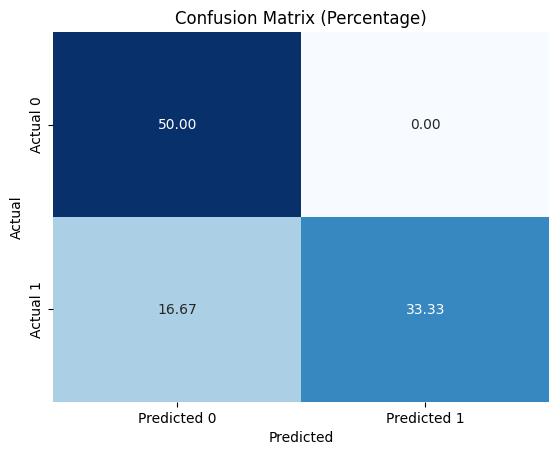

In [20]:
# Plot confusion matrix using seaborn
#conf_matrix_percentage = conf_matrix / len(y_test) * 100

sns.heatmap(conf_matrix_SVM / len(y_test_numpy) * 100, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()